In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
from os import mkdir
from os.path import join, exists

In [20]:
class Cell3D:
    def __init__(self,name,gen_path):
        self.save_path = join(gen_path, name)
        if not exists(self.save_path):
            mkdir(self.save_path)        

    def define_cell_dimensions(self,lx,ly,lz):
        self.lx = lx
        self.ly = ly
        self.lz = lz
    
    def generate_grid(self,nx,ny,nz):
        self.nx = nx
        self.ny = ny
        self.nz = nz
        self.dx = self.lx/self.nx
        self.dy = self.ly/self.ny
        self.dz = self.lz/self.nz
    
    def define_cell_thermal_properties(self, T_init, kx, ky, kz, cp, q_gen, rho):
        self.T_init = T_init
        self.kx = kx
        self.ky = ky
        self.kz = kz
        self.cp = cp
        self.q_gen = q_gen
        self.rho = rho

    def define_heat_sink_properties(self,hx1,Tx_inf1, hy1,Ty_inf1, hz1, Tz_inf1,hx2,Tx_inf2, hy2,Ty_inf2, hz2, Tz_inf2):
        self.hx1, self.Tx_inf1 = hx1, Tx_inf1
        self.hy1, self.Ty_inf1 = hy1, Ty_inf1
        self.hz1, self.Tz_inf1 = hz1, Tz_inf1
        self.hx2, self.Tx_inf2 = hx2, Tx_inf2
        self.hy2, self.Ty_inf2 = hy2, Ty_inf2
        self.hz2, self.Tz_inf2 = hz2, Tz_inf2
    
    def define_timestep(self,dt,Nt):
        self.dt = dt
        self.Nt = Nt
    
    def perform_base_computations(self):
        self.number_of_cells = self.nx*self.ny*self.nz
        self.cell_volume = self.lx*self.ly*self.lz
        self.q_gen_per_volume = self.q_gen/self.cell_volume
        self.q_gen_cell = self.q_gen_per_volume/(self.rho*self.cp)

    def create_matrices(self):
        self.T = np.ones((self.nx, self.ny, self.nz))*self.T_init
        self.T_new = np.copy(self.T)
    
    def create_plot(self, step_time):        
        plot_title = ["Cell Center-section","Cell Body"]
        plot_data = [self.T[:, :,0],self.T[:, :,self.nz//2]]
        for data,title in zip(plot_data,plot_title):
            plt.clf()
            min_val = np.min(data)
            max_val = np.max(data)               
            plt.imshow(data, origin='lower', extent=[0, self.lx*1000, 0, self.ly*1000], cmap='jet', interpolation='bilinear',
                     vmin = min_val, vmax=max_val)                               
            cbar = plt.colorbar(label='Temperature (K)')
            cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.2f}'))  # Format colorbar to 2 decimal places
            plt.title('Temperature Distribution at '+str(step_time)+' seconds - '+ title)
            plt.xlabel('X position (mm)')
            plt.ylabel('Y position (mm)')
            filename = title+"_"+str(step_time)+".jpg" 
            save_path = join(self.save_path,filename)
            plt.savefig(save_path)             
    
    def create_graph(self):
        fig,ax = plt.subplots(figsize=(16,6))
        plt.plot(self.time, self.mean_T,label="Mean Temperature")
        plt.plot(self.time, self.max_T,label="Max Temperature")
        plt.plot(self.time, self.min_T,label="Min Temperature")
        plt.grid(True)
        plt.legend()
        save_path = join(self.save_path,"temperature_profile.jpg")
        plt.savefig(save_path)

    def simulate(self, timesteps):
        self.time = []
        self.mean_T = []
        self.max_T = []
        self.min_T = []
        for step in range(self.Nt):
            for i in range(self.nx):
                for j in range(self.ny):
                    for k in range(self.nz):
                        if i==0:
                            self.T_new[i,j,k] = self.T[i+1,j,k]+(self.hx1*self.dx/self.kx)*(self.Tx_inf1-self.T[i,j,k])
                        elif i==self.nx-1:
                            self.T_new[i,j,k] = self.T[i-1,j,k]+(self.hx2*self.dx/self.kx)*(self.Tx_inf2-self.T[i,j,k])
                        elif j==0:
                            self.T_new[i,j,k] = self.T[i,j+1,k]+(self.hy1*self.dy/self.ky)*(self.Ty_inf1-self.T[i,j,k])
                        elif j==self.ny-1:
                            self.T_new[i,j,k] = self.T[i,j-1,k]+(self.hy2*self.dy/self.ky)*(self.Ty_inf2-self.T[i,j,k])
                        elif k==0:
                            self.T_new[i,j,k] = self.T[i,j,k+1]+(self.hz1*self.dz/self.kz)*(self.Tz_inf1-self.T[i,j,k])
                        elif k==self.nz-1:
                            self.T_new[i,j,k] = self.T[i,j,k-1]+(self.hz2*self.dz/self.kz)*(self.Tz_inf2-self.T[i,j,k])
                        else:
                            d2Tdx2 = (self.T[i+1,j,k] - 2*self.T[i,j,k] + self.T[i-1,j,k])/self.dx**2
                            d2Tdy2 = (self.T[i,j+1,k] - 2*self.T[i,j,k] + self.T[i,j-1,k])/self.dy**2
                            d2Tdz2 = (self.T[i,j,k+1] - 2*self.T[i,j,k] + self.T[i,j,k-1])/self.dz**2
                            self.T_new[i,j,k] += self.dt*(self.q_gen_cell+(self.kx*d2Tdx2 + self.ky*d2Tdy2 + self.kz*d2Tdz2)/(self.rho*self.cp))
                            
            self.T = np.copy(self.T_new)         
            if (step*self.dt).is_integer():
                step_time = step*self.dt
                self.time.append(step_time)
                mean_temp = np.mean(self.T)
                max_temp = np.max(self.T)
                min_temp = np.min(self.T)
                self.mean_T.append(mean_temp)
                self.max_T.append(max_temp)
                self.min_T.append(min_temp)
                if step_time in timesteps:
                    self.create_plot(step_time)
            

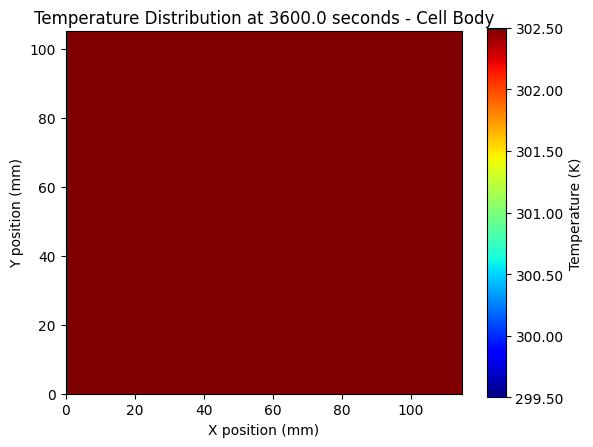

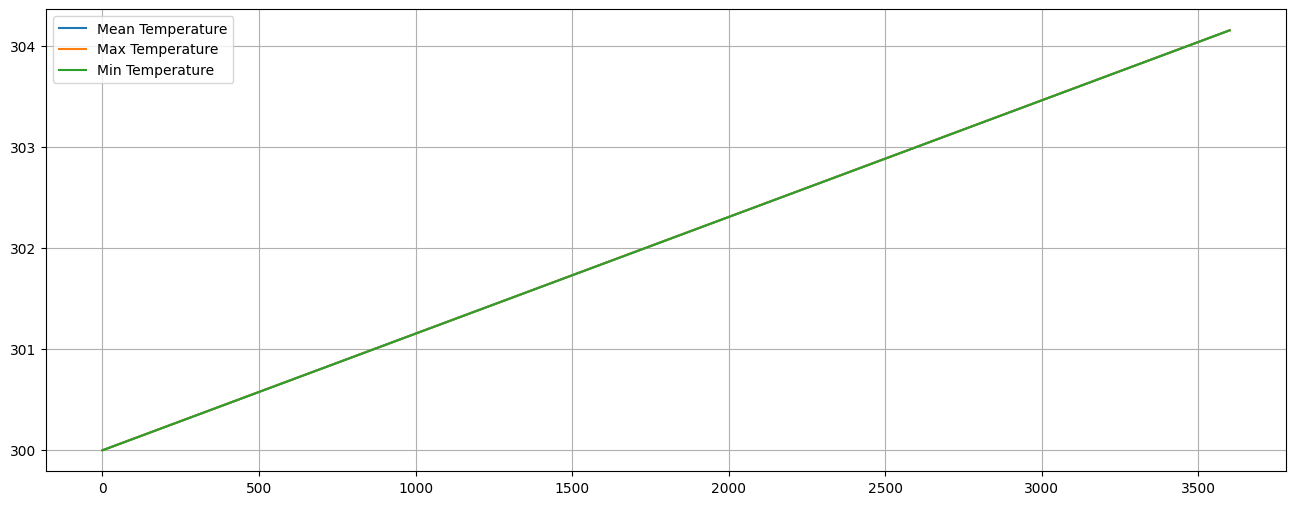

In [24]:
gen_path = r"/home/kage-main/Documents/01_Codes/02_projects/Cell_SOC_Model/thermal_model/jpegs"
cell = Cell3D("no_cooling",gen_path)
cell.define_cell_dimensions(0.115,0.105,0.022)
cell.generate_grid(20,20,10)
cell.define_cell_thermal_properties(300,36,36,1.3,1200,0.75,2032)
cell.define_heat_sink_properties(0,298,0,298,0,298,0,298,0,298,0,298)
cell.define_timestep(0.025,144040)
cell.perform_base_computations()
cell.create_matrices()
timesteps = [0,1,10,30,60,100,240,360,720,900,1200,1500,1800,2100,2400,2700,3000,3600]
cell.simulate(timesteps)
cell.create_graph()

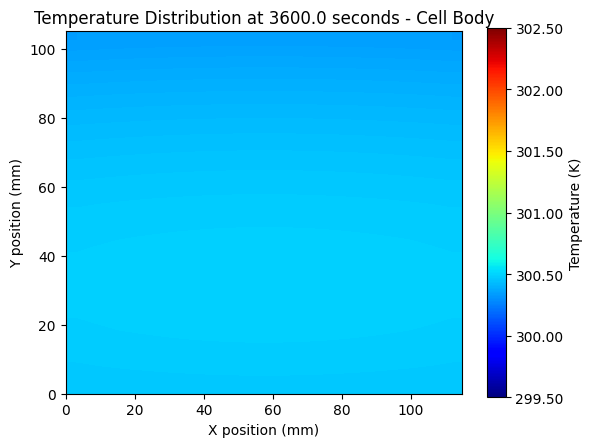

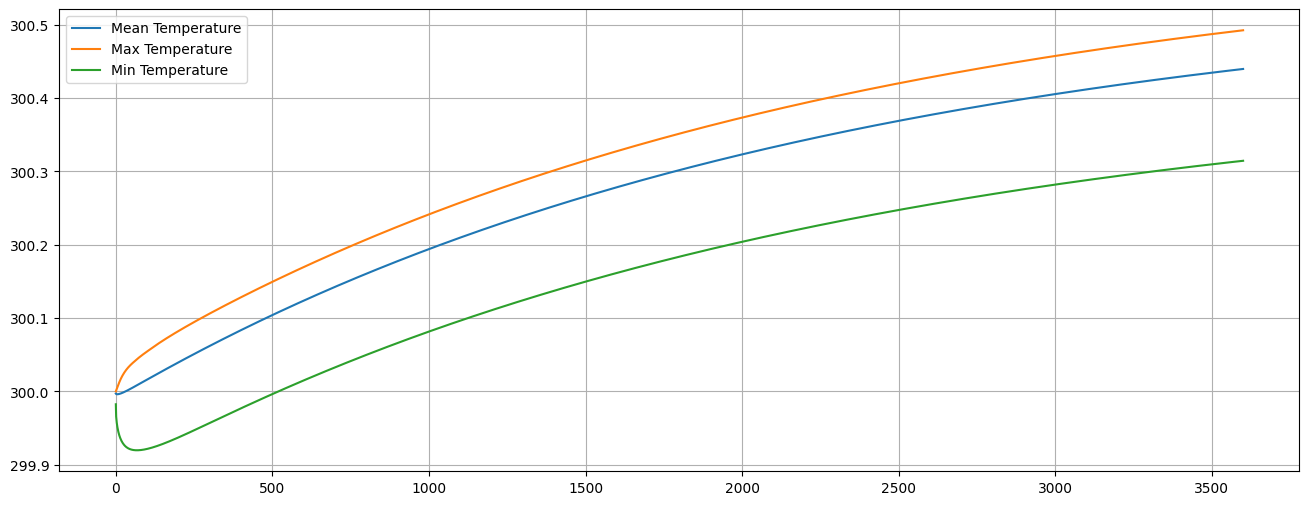

In [22]:
gen_path = r"/home/kage-main/Documents/01_Codes/02_projects/Cell_SOC_Model/thermal_model/jpegs"
cell = Cell3D("best_cooling",gen_path)
cell.define_cell_dimensions(0.115,0.105,0.022)
cell.generate_grid(20,20,10)
cell.define_cell_thermal_properties(300,36,36,1.3,1200,0.75,2032)
cell.define_heat_sink_properties(20,298,3,298,3,298,55,298,3,298,3,298)
cell.define_timestep(0.025,144040)
cell.perform_base_computations()
cell.create_matrices()
timesteps = [0,1,10,30,60,100,240,360,720,900,1200,1500,1800,2100,2400,2700,3000,3600]
cell.simulate(timesteps)
cell.create_graph()

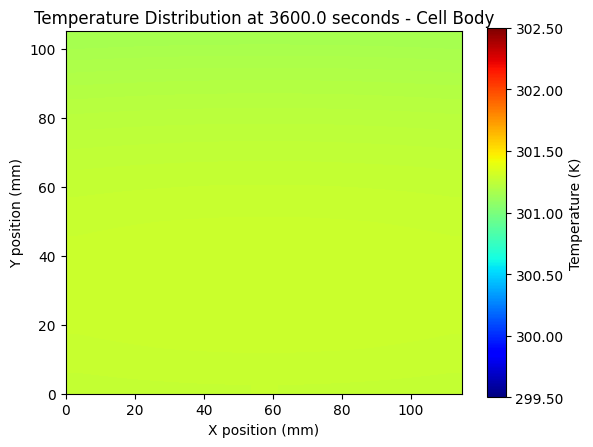

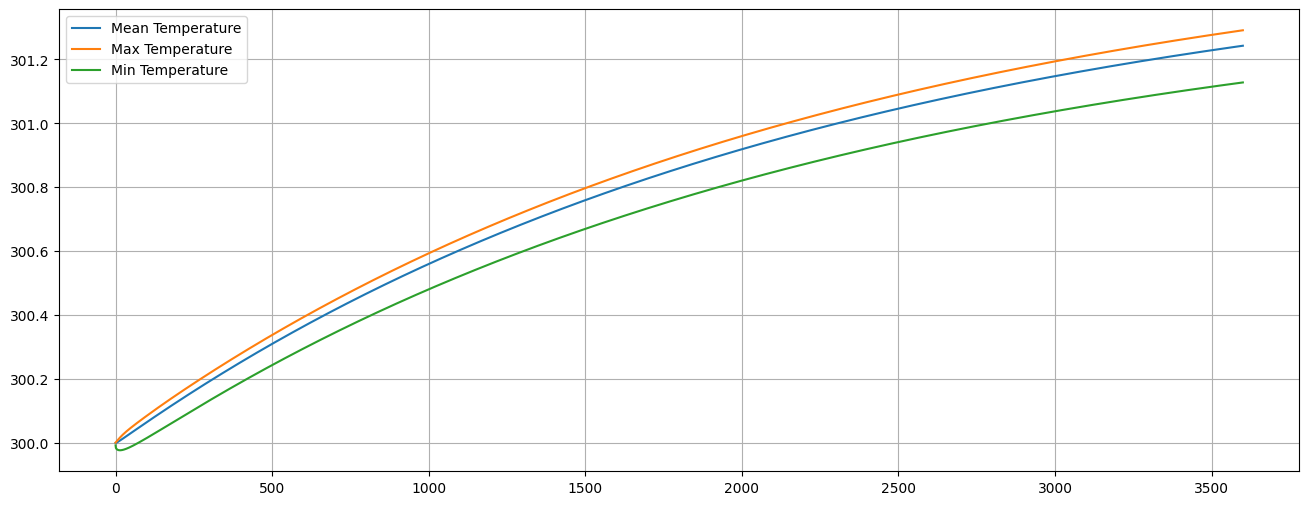

In [25]:
gen_path = r"/home/kage-main/Documents/01_Codes/02_projects/Cell_SOC_Model/thermal_model/jpegs"
cell = Cell3D("worst_cooling",gen_path)
cell.define_cell_dimensions(0.115,0.105,0.022)
cell.generate_grid(20,20,10)
cell.define_cell_thermal_properties(300,36,36,1.3,1200,0.75,2032)
cell.define_heat_sink_properties(20,299,3,299,3,299,55,299,3,299,3,299)
cell.define_timestep(0.025,144040)
cell.perform_base_computations()
cell.create_matrices()
timesteps = [0,1,10,30,60,100,240,360,720,900,1200,1500,1800,2100,2400,2700,3000,3600]
cell.simulate(timesteps)
cell.create_graph()

KeyboardInterrupt: 

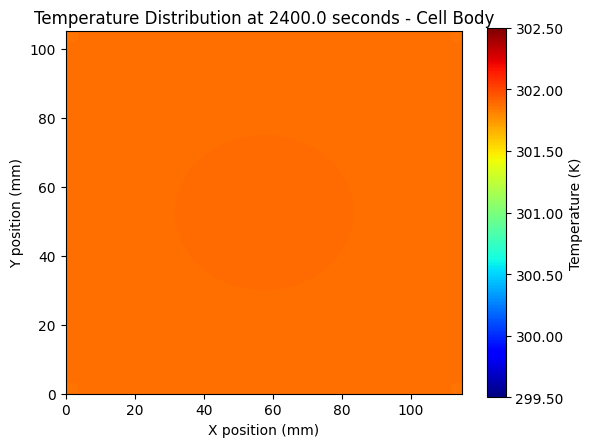

In [26]:
gen_path = r"/home/kage-main/Documents/01_Codes/02_projects/Cell_SOC_Model/thermal_model/jpegs"
cell = Cell3D("minimal_cooling_base",gen_path)
cell.define_cell_dimensions(0.115,0.105,0.022)
cell.generate_grid(20,20,10)
cell.define_cell_thermal_properties(300,36,36,1.3,1200,0.75,2032)
cell.define_heat_sink_properties(3,299,3,299,3,299,3,299,3,299,3,299)
cell.define_timestep(0.025,144040)
cell.perform_base_computations()
cell.create_matrices()
timesteps = [0,1,10,30,60,100,240,360,720,900,1200,1500,1800,2100,2400,2700,3000,3600]
cell.simulate(timesteps)
cell.create_graph()